In [317]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import callbacks
import csv
from PIL import Image
import tensorflow as tf
import pathlib
import os

In [187]:
# Read train.csv
imageData = []
with open('./train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    for row in csv_reader:
        imageData.append(row)

In [314]:
# Extract the different species
species = []
for i in range(1, len(imageData)):
    if imageData[i][1] not in species:
        species.append(imageData[i][1])
        
print(len(species))

30


In [199]:
# Create a label dict for species
speciesDict = {}
for i in range(len(species)):
    speciesDict[species[i]] = i
    

In [190]:
# Create a label dict for image and species
imageSpeciesDict = {}
for i in range(len(imageData)):
    imageSpeciesDict[imageData[i][0]] = imageData[i][1]
    


## Gather Training Images with Labels

In [297]:
# Importing images with labels
train_images = pathlib.Path('/home/sean/.keras/datasets/organized_train_images')

train_list_ds = tf.data.Dataset.list_files(str(train_images/'*/*'))

# dirs = [x for x in os.walk(train_images)]

# print(dirs)

# files = []

# for file in os.listdir(train_images):
#     d = os.path.join(train_images, file)
#     if os.path.isdir(d):
#         for f in os.listdir(d):
#             x = os.path.join(d, f)
#             files.append(x)

# for i in train_list_ds.take(1):
#     print(i.numpy().decode("utf-8"))

def process_path(file_path):
#     label = tf.strings.split(file_path, os.sep)[-2]
    parts = tf.strings.split(file_path, os.sep)
#     label = speciesDict[parts[-2]]
#     print(parts[-2].numpy.decode('utf-8'))
#     print(file_path)
#     label = parts[-2].numpy().decode("utf-8")
    label = int(parts[-2])
#     parts = file_path.split('/')
#     label = speciesDict[parts[-2]]
    
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [32,32])
    image = tf.reshape(image, [32,32,3])
    return image, label
#     return tf.io.read_file(file_path), label


train_labeled_ds = train_list_ds.map(process_path)

# train_labeled_ds = []
# for i in files:
#     parts = i.split('/')
#     label = speciesDict[parts[-2]]
    
#     image = tf.io.read_file(i)
#     image = tf.io.decode_jpeg(image)
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize(image, [128, 128])
#     train_labeled_ds.append((image, label))
    
# train_labeled_ds = map(process_path, files)

print(train_labeled_ds)
# train_labeled_ds = tf.reshape(train_labeled_ds, [128, 128, 3])
# print(train_labeled_ds)

# dataset = tf.data.Dataset.from_tensors(train_labeled_ds)
# print(dataset)

# train_labeled_ds = train_labeled_ds.reshape(128, 128, 3)

for image_raw, label_text in train_labeled_ds.take(1):
    print(image_raw)
    print()
    print(label_text.numpy())


<MapDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
tf.Tensor(
[[[0.54178923 0.5457108  0.5613971 ]
  [0.539905   0.5438266  0.55951285]
  [0.517402   0.53700984 0.54877454]
  ...
  [0.5249847  0.5367494  0.55635726]
  [0.54656863 0.55833334 0.5779412 ]
  [0.5443628  0.5639706  0.5796569 ]]

 [[0.5067402  0.5224265  0.5341912 ]
  [0.5525276  0.5682139  0.5799786 ]
  [0.5228401  0.53852636 0.55029106]
  ...
  [0.57405025 0.58581495 0.6054228 ]
  [0.5817402  0.58566177 0.60134804]
  [0.59214157 0.59606314 0.6039063 ]]

 [[0.54928005 0.56104475 0.5806526 ]
  [0.518505   0.5381128  0.5498775 ]
  [0.51600796 0.5199295  0.5356158 ]
  ...
  [0.5192402  0.5203432  0.52254903]
  [0.55946696 0.5633885  0.57123166]
  [0.547304   0.547304   0.5495098 ]]

 ...

 [[0.52962625 0.5453125  0.5570772 ]
  [0.4020987  0.41778496 0.42170653]
  [0.5693321  0.5850184  0.58673406]
  ...
  [0.55903804 0.5629596  0.57080275]
  [

## Gathering Test Images 

In [298]:
# Importing images
test_images = pathlib.Path('/home/sean/.keras/datasets/test_images')


test_list_ds = tf.data.Dataset.list_files(str(test_images/'*'))

def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [32,32])
    image = tf.reshape(image, [32,32,3])
    return image

# test_ds = tf.data.Dataset.from_tensors(test_list_ds.map(process_path))
test_ds = test_list_ds.map(process_path)

print(test_ds)
# for image_raw in test_ds.take(1):
#     print(repr(image_raw.numpy()[:100]))

<MapDataset element_spec=TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None)>


## Image Parsing

In [140]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label


def parse_image_test(filename):
    parts = tf.strings.split(filename, os.sep)

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])

    return image



## Showing an Image

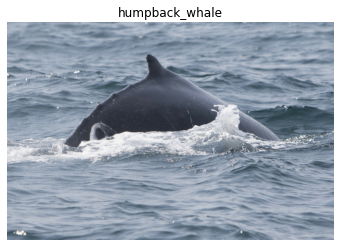

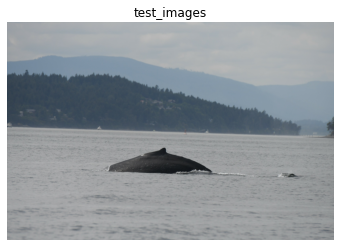

In [12]:
# Show an image
file_path = next(iter(train_list_ds))
image1, label1 = parse_image(file_path)

file_path = next(iter(test_list_ds))
image2, label2 = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image1, label1)
show(image2, label2)


## Reshaping Data

In [150]:


# parsed_train_ds = train_list_ds.map(parse_image)
# (X_train, y_train) = train_list_ds.map(parse_image)
# # parsed_test_ds = test_list_ds.map(parse_image)
# parsed_test_ds = test_list_ds.map(parse_image_test)

print(train_labeled_ds)

# train_images = train_images / 255

# print(tf.reshape(parsed_train_ds.element_spec[0], [128, 128, 3]))
# tf.convert_to_tensor(parsed_train_ds, dtype=tf.float32)
# print(train_images)
# print(test_images)

# for i in range(len(parsed_train_ds)):
#     print(parsed_train_ds[i])


# for image, label in parsed_train_ds:
#     if image.shape[2] == None:
# #         image = tf.image.grayscale_to_rgb(image, name=None)
#         print('------------------------------')
#     print(image.shape)

# X = np.concatenate(parsed_train_ds, axis=0).astype('float32') # all columns but the last
# y = np.concatenate(parsed_train_ds, axis=0).astype('float32') # the last column


# train_cnn = parsed_train_ds.reshape(51033, 128, 128, 3).astype('float32')
# test_cnn = parsed_test_ds.reshape(27956, 128, 128, 3).astype('float32')

<MapDataset element_spec=(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


## Batching Training Images

In [322]:
# batching images
batched_training_ds = train_labeled_ds.batch(16)
batched_test_ds = test_ds.batch(16)
print(batched_training_ds)
print(batched_test_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>


## Plot Batched Dataset

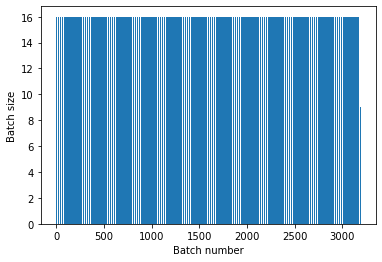

In [32]:
# Plot the batched data
def plot_batch_sizes(ds):
    batch_sizes = [batch[0].shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')
    
plot_batch_sizes(batched_training_dataset)

## Shuffling Data

In [108]:
# dataset = tf.data.Dataset.zip(batched_training_dataset)
# shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

# print("Here are the item ID's near the epoch boundary:\n")
# for n, line_batch in shuffled.skip(60).take(5):
#   print(n.numpy())

## Build CNN Model

In [315]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    
#     model.add(Conv2D(32, (3, 3), padding='same', input_shape = (128, 128, 1), activation = 'relu'))
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.5)) # antes era 0.25

    model.add(Conv2D(32, (3, 3), input_shape = (32, 32, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(30))
    
#     model.add(Dense(units = 512, activation = 'relu'))
#     model.add(Dropout(0.5)) 
#     model.add(Dense(units = 6, activation = 'softmax'))
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#     # Adding a second convolutional layer
#     model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.5)) # antes era 0.25

#     # Adding a third convolutional layer
#     model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.5)) # antes era 0.25

#     # Step 3 - Flattening
#     model.add(Flatten())

#     # Step 4 - Full connection
#     model.add(Dense(units = 512, activation = 'relu'))
#     model.add(Dropout(0.5)) 
#     model.add(Dense(units = 6, activation = 'softmax'))

    # Compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Train

In [323]:
%%time

# train_labeled_ds = tf.convert_to_tensor(train_labeled_ds)
print(batched_training_ds)
print(batched_test_ds)

# for image, label in parsed_train_ds:
#     print(image.shape)
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Check out the layers in our model
model_cnn.summary()
# Fit the model
model_cnn.fit(batched_training_ds, validation_data=batched_test_ds, epochs=25, callbacks =[earlystopping])
# model_cnn.fit(train_labeled_ds, validation_data=test_ds, epochs=10, batch_size=16)
# Final evaluation of the model
plt.plot(model_cnn.history['accuracy'], label='accuracy')
plt.plot(model_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

scores = model_cnn.predict(batched_test_ds, verbose=0)
print('Final CNN accuracy: ', scores)

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_189 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 6, 6, 64)         0         
 ng2D)                                                           
         

KeyboardInterrupt: 